## 미션 1. 

In [1]:
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm # 글꼴을 시스템에 등록
import seaborn as sb
import numpy as np
from hossam import load_data
import pandas as pd
from pandas import DataFrame
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, pearsonr, spearmanr
from itertools import combinations

# 로지스틱 결과 판별 참조 + 머신러닝 라이브러리
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, recall_score, precision_score, f1_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
origin = load_data('insurance')
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")
print(origin.info())
origin.head()

[data] https://data.hossam.kr/data/kaggle/insurance.xlsx
[desc] 개인의 나이·성별·BMI·흡연 여부·거주 지역 등 기본 건강·인구학적 정보를 바탕으로 의료보험 청구 비용(charges)을 예측하도록 구성된, 선형회귀와 머신러닝 실습에 널리 사용되는 대표적인 보험 비용 데이터셋 (출처: https://www.kaggle.com/datasets/mirichoi0218/insurance)

변수명    의미(설명)
--------  ---------------------------------------------------------------
age       가입자의 나이(세).
sex       성별 (male, female).
bmi       체질량 지수(Body Mass Index).
children  부양 자녀 수(보험 내 자녀 수).
smoker    흡연 여부 (yes / no).
region    미국 내 거주 지역 (northeast, northwest, southeast, southwest).
charges   의료보험 청구 비용(달러). 예측해야 하는 타깃 변수.

데이터셋 크기: (1338, 7)
열 개수: 7
행 개수: 1338
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   objec

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
my_dpi = 200
font_path = 'C:\\Users\\wodyd\\Documents\\카카오톡 받은 파일./MaruBuri-Regular.ttf'
fm.fontManager.addfont(font_path)
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()
my_font_name = 'MaruBuri'
my_theme = 'dark'
sb.set_theme(style = my_theme)

plt.rcParams['font.family'] = my_font_name
plt.rcParams['font.size'] = 10
plt.rcParams['axes.unicode_minus'] = False

In [46]:
display(origin.describe().T)
print(origin.isna().sum())
display(origin[['sex','smoker','region']].nunique())
display(origin[['sex']].value_counts(normalize = True) * 100)
display(origin[['smoker']].value_counts(normalize = True) * 100)
display(origin[['region']].value_counts(normalize = True) * 100)

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


sex       2
smoker    2
region    4
dtype: int64

sex   
male      50.523169
female    49.476831
Name: proportion, dtype: float64

smoker
no        79.521674
yes       20.478326
Name: proportion, dtype: float64

region   
southeast    27.204783
northwest    24.289985
southwest    24.289985
northeast    24.215247
Name: proportion, dtype: float64

- 해당 데이터 셋에서 결측치는 발견되지 않았다. 하지만 'charges'에서 평균값이 중앙값보다 높게 나온것으로 보아, 이상치가 존재한다는 것으로 판단된다.
  'charges' 에 한정하여, 후에 로그 변환을 통해 정규성과 등분산성을 보다 잘 만족시키도록 개선한다.

- 기초통계량을 통해 확인한 결과, 'charges'변수에서 음수 값은 존재하지 않으나, 고액 의료비에 해당하는 관측치로 인해 극단값이 확인된다.

- 범주형 변수(sex, smoker, region)은 각각 2개, 2개, 4개의 범주로 구성되어 있고, 'smoker'변수의 경우 수치적으로는 데이터가 몰림이 있다.

- 기초통계량 및 분포 확인 결과, 데이터 품질이 전반적으로 양호하여 결측치 제거 또는 이상치 삭제와 같은 강한 전처리는 필요하지 않았다.

- 'charges'의 평균 값은 13270 USD로 한국 돈으로 환산하면 대략 1900만원이다. 의료비가 매우 비싼 미국이라는 점을 감안하면, 비현실적이라고 볼 수는 없으나,

  보험 플랜, 보장 범위 등 여러 요인을 고려하면 현실적인 의료비 수준인지 본 데이터 셋만으로는 설명하기 어렵다.

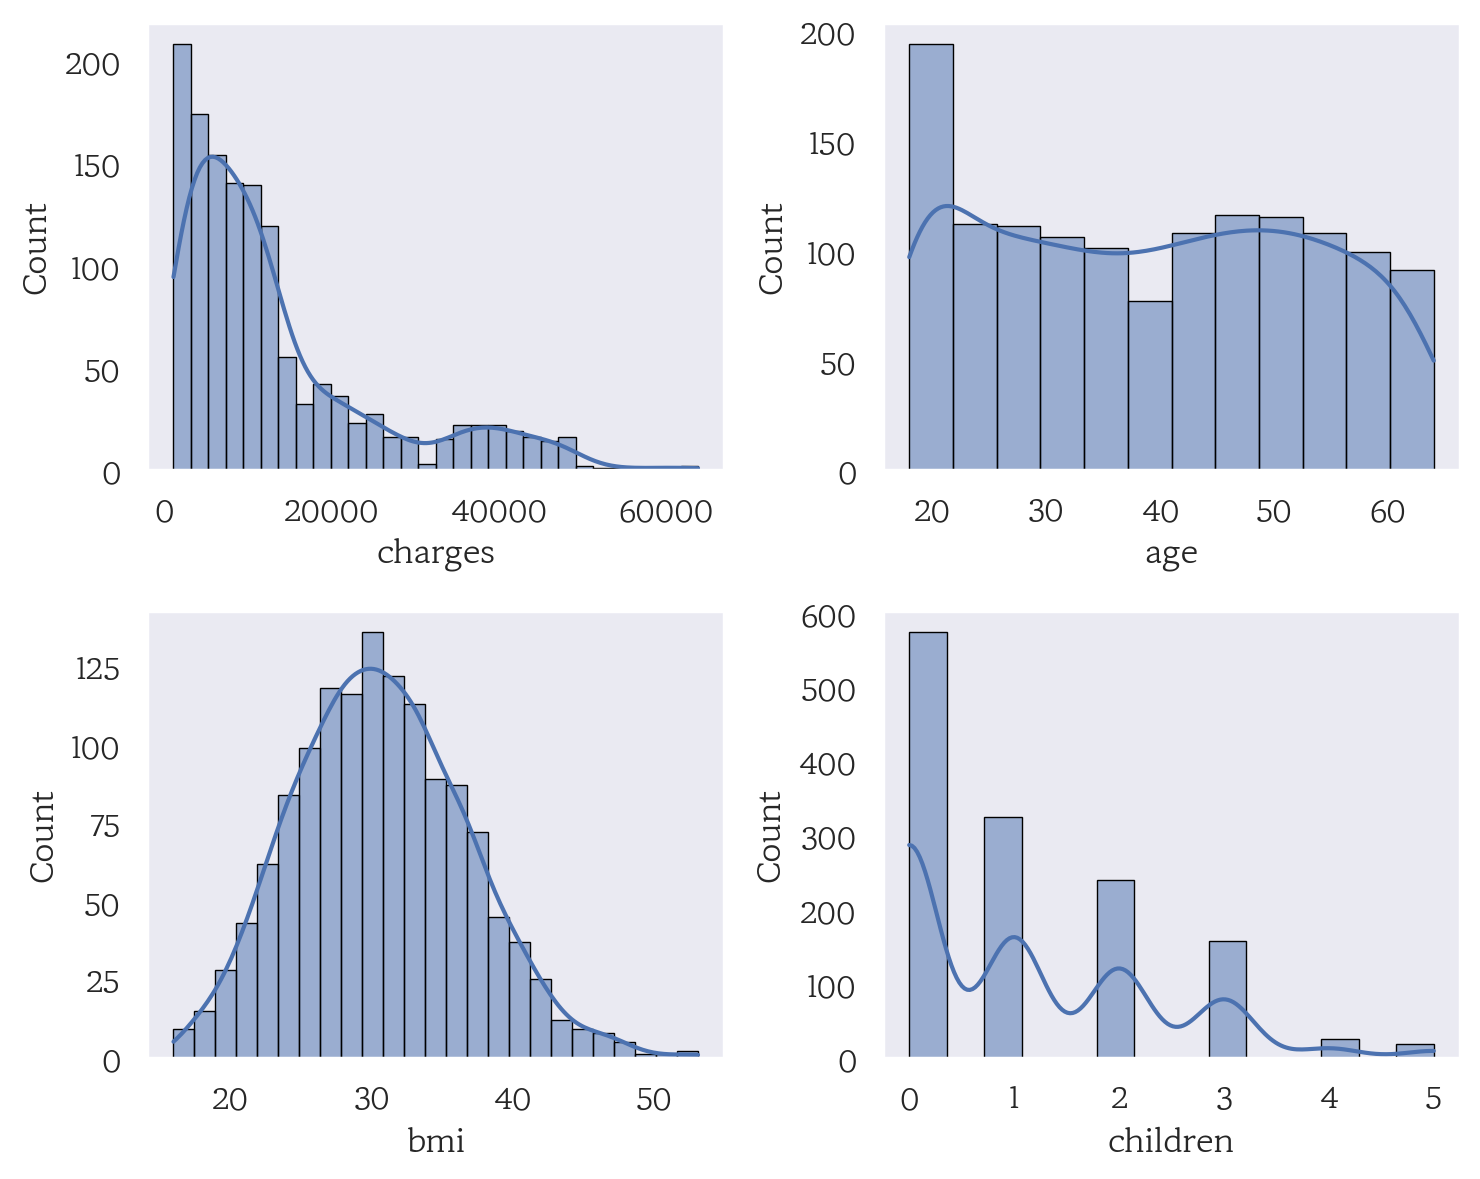

In [57]:
width_px = 1500
height_px = 1200
rows = 2
cols = 2
figsize = (width_px/ my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

# histogram 그리기
sb.histplot(data = origin, x = 'charges', kde = True, ax = ax[0][0],
            edgecolor ='#000000', linewidth = 0.5)
sb.histplot(data = origin, x = 'age', kde = True, ax = ax[0][1],
            edgecolor ='#000000', linewidth = 0.5)
sb.histplot(data = origin, x = 'bmi', kde = True, ax = ax[1][0],
            edgecolor ='#000000', linewidth = 0.5)
sb.histplot(data = origin, x = 'children', kde = True, ax = ax[1][1],
            edgecolor ='#000000', linewidth = 0.5)


# 출력
plt.tight_layout()
plt.show()
plt.close()


- charges를 제외한 나머지 변수들은 분포 범위가 제한적이며 극단적으로 긴 꼬리를 보이지 않는다.

  age와 bmi는 비교적 안정적인 범위 내에서 분포하며,

  charges는 다른 변수들과 비교했을 때 분포의 비대칭성이 가장 크다.

- 이상치가 존재하는 경우, 변수에 대한 설명력이 저하되며 

  왜도가 심한 경우, 잔차의 분산이 고르지 않아 등분산성 가정 위배가 발생하며 회귀계수에 대한 신뢰성이 떨어진다.

- 로그변환은 비대칭성을 완화하고, 분산을 안정화하며, 등분산성 가정 충족 여부를 보다 원활하게 만들어 준다.

In [24]:
origin.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


- 기초통계량 확인 결과, charges를 제외한 대부분의 변수들은 평균과 중앙값이 유사하게 나타나 분포의 왜곡이 크지 않으며, 현실적인 범위 내에서 관측값이
  분포하고 있음을 확인하였다.

- 반면 charges 변수는 평균이 중앙값보다 크게 나타나고 IQR 대비 최대값이 커, 고액 의료비에 해당하는 극단값이 존재하는 우편향 분포를 보였다.

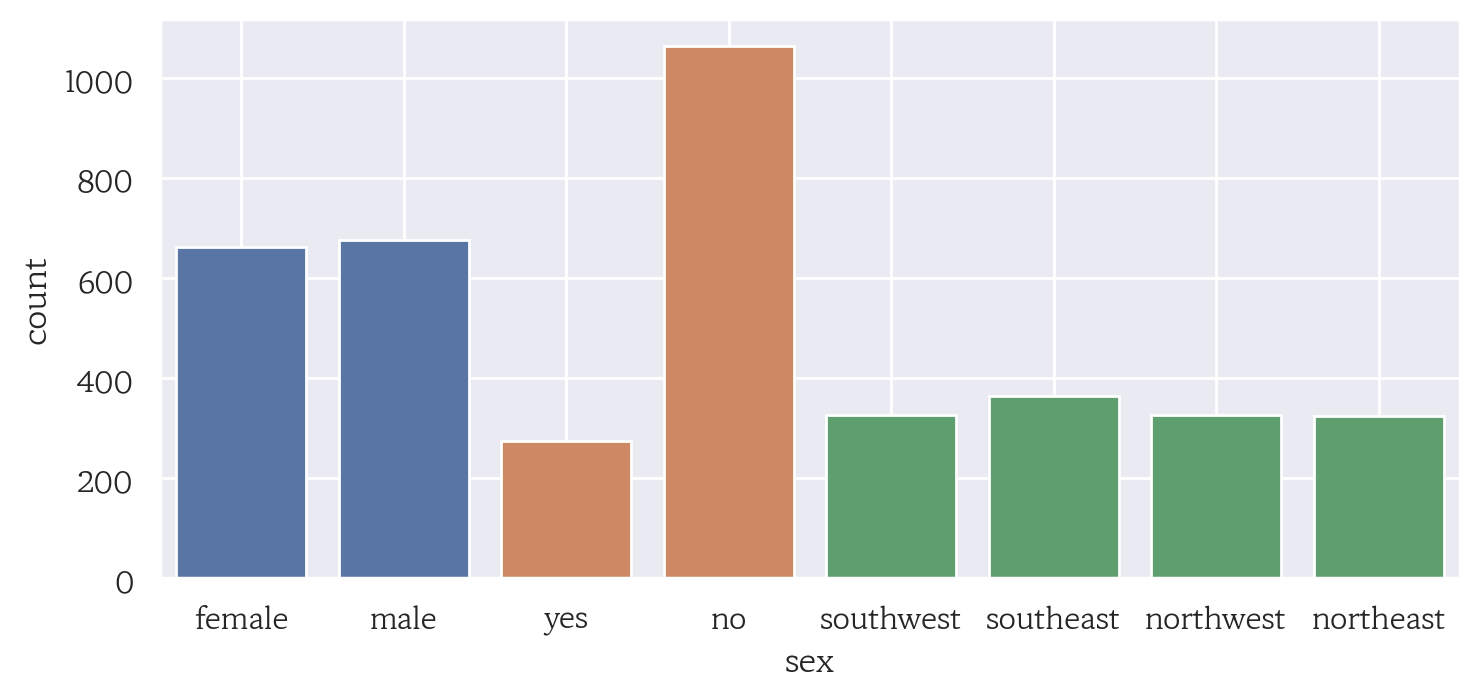

In [26]:
width_px = 1500
height_px = 720
rows = 1
cols = 1
figsize = (width_px/ my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

# count 그리기
sb.countplot(data=origin, x ='sex')       
sb.countplot(data=origin, x ='smoker')       
sb.countplot(data=origin, x ='region')       
ax.grid(True)

# 출력
plt.tight_layout()
plt.savefig('myplot.png', dpi = my_dpi)
plt.show()
plt.close()